# Building a Semantic Retrieval System for Book Discovery Using TF-IDF, NMF, and Cosine Similarity

**COSCI210 - Data Mining and Wrangling 1**

**Jose Miguel Bautista, PhD**
  
*Lab Report 2/Final Project*

**<u>MSDS 2026 Learning Team 8, Term 2</u>**

- Francis Erdey M. Capati
   
- Kevin Ansel S. Dy

- Jan Paolo V. Moreno

- Mia Cielo G. Oliveros

## Abstract
This paper presents an end-to-end semantic search pipeline designed to assist bookstore retailers in identifying fiction titles relevant to a customer’s requested themes or topics. Using Penguin Random House’s API as a metadata source, we construct a corpus of fiction titles and apply a multi-stage natural language processing (NLP) workflow. The flap-copy descriptions undergo TF-IDF vectorization, followed by Non-Negative Matrix Factorization (NMF) for topic extraction. A cosine similarity ranking layer enables semantic retrieval, allowing users to submit free-form text queries and receive the most relevant book titles. The resulting system enables accurate, interpretable topic-aligned book recommendations suitable for curation.

## Introduction and Problem Definition

A bookstore customer requests recommendations for titles aligned with specific themes or topics. The objective is to build a semantic retrieval system that returns relevant fiction books from the retailer’s inventory. The challenge is to interpret free-form text queries and identify the most semantically aligned titles using book metadata.

## Data Acquisition from Penguin Random House API

The corpus is constructed from Penguin Random House’s metadata service, accessed via a secure API key.

2.1. Collecting Fiction Category Identifiers

Fiction BISAC categories are retrieved from PRH endpoints and stored locally in a JSON file for reference.

These category IDs form the basis for selecting relevant books to include in the corpus.

2.2. Batch Retrieval of Title Metadata
A custom function accepts:

A list of category IDs

A record count per category

A set of API parameters

The function returns a list of data frames, each containing:

|ISBN|
|--|
|Title|
|Author|
|Flap-copy description|

These fields form the raw text corpus for downstream NLP processing.

In [10]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
import json
import re
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
CAT = "https://api.penguinrandomhouse.com/resources/v2/domains/PRH.US/categories/"
TITLE_CAT = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/"
session = requests.Session()

In [11]:
BISAC = pd.read_json("bisac_prefixes.json", typ="series").reset_index()
BISAC.columns = ["prefix", "category"]
BISAC

,prefix,category
0,ANT,Antiques & Collectibles
1,ARC,Architecture
2,BIB,Bibles
3,BIO,Biography & Autobiography
4,BOD,"Body, Mind & Spirit"
5,BUS,Business & Economics
6,CGN,Comics & Graphic Novels
7,COM,Computers
8,CKB,Cooking
9,CRA,Crafts & Hobbies


In [12]:
with open('fiction_BISAC.json', 'r') as f:
    fiction_bisac_codes = json.load(f)
fiction_bisac_codes = fiction_bisac_codes.get('data')
fiction_bisac_codes
f_cat_map = {
    c["catId"]: c["menuText"]
    # c["catId"]: {
    #     "BISAC": c["catUri"],
    #     "Description": c["menuText"]
        for c in fiction_bisac_codes["categories"]
}
f_cat_map

{3000001525: 'Fiction',
 3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001544: 'Christian',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001551: 'Historical',
 3000001552: 'Romance',
 3000001553: 'Historical',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',

In [13]:
len(f_cat_map)

369

In [38]:
f_cat_id = {}
for key, value in f_cat_map.items():
    if value not in f_cat_id.values():
        f_cat_id[key] = value
del f_cat_id[3000001525]
f_cat_id

{3000001526: 'Absurdist',
 3000001527: 'Action & Adventure',
 3000001528: 'Adaptations & Pastiche',
 3000001529: 'African American & Black',
 3000001530: 'Christian',
 3000001531: 'Erotica',
 3000001532: 'Historical',
 3000001533: 'Mystery & Detective',
 3000001534: 'Urban & Street Lit',
 3000001535: 'Women',
 3000001536: 'Alternative History',
 3000001537: 'Amish & Mennonite',
 3000001538: 'Animals',
 3000001539: 'Anthologies (multiple authors)',
 3000001540: 'Asian American & Pacific Islander',
 3000001541: 'Biographical & Autofiction',
 3000001542: 'Books, Bookstores & Libraries',
 3000001543: 'Buddhist',
 3000001545: 'Biblical',
 3000001546: 'Classic & Allegory',
 3000001547: 'Collections & Anthologies',
 3000001548: 'Contemporary',
 3000001549: 'Fantasy',
 3000001550: 'Futuristic',
 3000001552: 'Romance',
 3000001555: 'Suspense',
 3000001556: 'Western',
 3000001558: 'City Life',
 3000001559: 'Classics',
 3000001560: 'Coming Of Age',
 3000001561: 'Crime',
 3000001562: 'Cultural Her

In [6]:
f_cat_id[3000001771]

'Romantic Comedy'

In [39]:
def build_corpus(f_cat_id, total_categories=3, rows=10):
    API_KEY = "fh5hj47dynk4nvx4s9ewufj4"
    BASE = "https://api.penguinrandomhouse.com/resources/v2/title/domains/PRH.US/titles/views/istca"
    CAT = "https://api.penguinrandomhouse.com/resources/v2/domains/PRH.US/categories/"
    session = requests.Session()

    results = []
    counter = 0
    for catId in f_cat_id:
        if counter < total_categories:
            params = {
                "formatFamily": "Paperback",
                "catId": catId,
                "showFlapCopy": "true",
                "showPublishedBooks": "true",
                "start": 0,
                "rows": rows,
                "api_key": API_KEY,
            }
    
            try:
                r = session.get(BASE, params=params, timeout=20)
                r.raise_for_status()
    
            except requests.exceptions.Timeout:
                #print(f"\n[TIMEOUT] Category {catId} timed out. Skipping.")
                continue
    
            except requests.exceptions.ConnectionError:
                #print(f"\n[CONNECTION ERROR] Failed to connect for category {catId}. Skipping.")
                continue
    
            except requests.exceptions.HTTPError as http_err:
                #print(f"\n[HTTP ERROR] Category {catId}: {http_err}. Skipping.")
                continue
    
            except Exception as e:
                #print(f"\n[UNKNOWN ERROR] Category {catId}: {e}. Skipping.")
                continue
    
            #print("\n---")
            #print("CATID:", catId)
            #print("STATUS:", r.status_code)
            #print("URL:", r.url)
            #print("RAW:", r.text[:200])
    
            r.raise_for_status()
            r_dict = r.json()
            for i in r_dict['data']:
                i['catId'] = catId
            results.append(r_dict)
            counter += 1
        else:
            break
    
    # Build the dataframe
    corpus = pd.DataFrame(results[0]['data'])
    #catid_corpus_dict = {}

    for catid in results:
        df = pd.DataFrame(catid['data'])
        try:
            corpus = pd.concat([corpus, df], ignore_index=True)
            #catid_corpus_dict[catid['params']['catId']] = len(catid['data'])
        except NameError:
            corpus = df

    corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
        'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
        'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
        'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
        'series', 'language', 'seq', 'titleBlock', 'authors'])

    return corpus

In [82]:
corpus = build_corpus(f_cat_id, total_categories=3, rows=100)
# for catid in fetch:
#     df = pd.DataFrame(catid['data'])
#     try:
#         corpus = pd.concat([corpus, df], ignore_index=True)
#     except NameError:
#         corpus = df

# corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
#        'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
#        'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
#        'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
#        'series', 'language', 'seq', 'titleBlock', 'authors'])
# # corpus.set_index('isbn', inplace=True)
corpus

,isbn,title,author,description,catId
0,9780140154078,The Music of Chance,Paul Auster,<b>An &ldquo;exceptional&rdquo; (<i>Los Angele...,3000001526
1,9780142001813,Homo Zapiens,Victor Pelevin,The collapse of the Soviet Union has opened up...,3000001526
2,9780241678916,The Castle,Franz Kafka; Translated by J. A. Underwood; In...,<b>An acclaimed translation of the final work ...,3000001526
3,9780385492102,El Anatomista,Federico Andahazi,Publicada por aclamaci&#243;n p&#250;blica en ...,3000001526
4,9780425253373,Lunatics,Dave Barry,"<b>Philip Horkman is a happy man, the owner of...",3000001526
...,...,...,...,...,...
291,9781594744426,Sense and Sensibility and Sea Monsters,Jane Austen and Ben H. Winters,<b><i>New York Times</i> bestseller<br><br>An ...,3000001528
292,9781594744600,Android Karenina,Leo Tolstoy and Ben H. Winters,<b>Leo Tolstoy meets robots in this &ldquo;cre...,3000001528
293,9781789097313,Uncharted: The Official Movie Novelization,S.D. Perry,<b>The official novelization of the hotly anti...,3000001528
294,9781913029692,2+2=5,Jake Chapman,<b>A riotous new take on a classic fictional d...,3000001528


In [17]:
#corpus = pd.read_json('fiction_corpus.json')
#corpus = corpus.drop(columns=['isbnHyphenated', 'workId', 'coverUrl',
#        'format', 'subformat', 'binding', 'editionTarget', 'trim', 'edition',
#        'onSaleDate', 'exportOnSaleDate', 'price', 'exportPrice',
#        'globalDivision', 'publishingDivision', 'imprint', 'publishingStatus',
#        'series', 'language', 'seq', 'titleBlock', 'authors'])
#corpus

In [83]:
corpus.loc[:, 'description'] = (
    corpus['description']
        .str.replace(r"<.*?>", "", regex=True)            
        .str.replace(r"&[A-Za-z0-9#]+;", "", regex=True)  
        .str.replace(r"\d+", "", regex=True)              
        .str.strip()
)
corpus = corpus.drop_duplicates(subset=['title'], keep='first')
corpus.reset_index(drop=True, inplace=True)
corpus

,isbn,title,author,description,catId
0,9780140154078,The Music of Chance,Paul Auster,An exceptional (Los Angeles Times) novel of fa...,3000001526
1,9780142001813,Homo Zapiens,Victor Pelevin,The collapse of the Soviet Union has opened up...,3000001526
2,9780241678916,The Castle,Franz Kafka; Translated by J. A. Underwood; In...,An acclaimed translation of the final work by ...,3000001526
3,9780385492102,El Anatomista,Federico Andahazi,"Publicada por aclamacin pblica en Argentina, E...",3000001526
4,9780425253373,Lunatics,Dave Barry,"Philip Horkman is a happy man, the owner of a ...",3000001526
...,...,...,...,...,...
192,9781594744426,Sense and Sensibility and Sea Monsters,Jane Austen and Ben H. Winters,New York Times bestsellerAn uproarious tale of...,3000001528
193,9781594744600,Android Karenina,Leo Tolstoy and Ben H. Winters,"Leo Tolstoy meets robots in this creepy, thril...",3000001528
194,9781789097313,Uncharted: The Official Movie Novelization,S.D. Perry,The official novelization of the hotly anticip...,3000001528
195,9781913029692,2+2=5,Jake Chapman,A riotous new take on a classic fictional dyst...,3000001528


In [84]:
corpus.shape

(197, 5)

#### Step 1. Establish corpus

In [85]:
# Focus on descriptions only
working_corpus = corpus['description']
working_corpus

0      An exceptional (Los Angeles Times) novel of fa...
1      The collapse of the Soviet Union has opened up...
2      An acclaimed translation of the final work by ...
3      Publicada por aclamacin pblica en Argentina, E...
4      Philip Horkman is a happy man, the owner of a ...
                             ...                        
192    New York Times bestsellerAn uproarious tale of...
193    Leo Tolstoy meets robots in this creepy, thril...
194    The official novelization of the hotly anticip...
195    A riotous new take on a classic fictional dyst...
196    The pilot episode of a TV series that perverse...
Name: description, Length: 197, dtype: object

## TF-IDF Vectorization of Flap-Copy Descriptions

TF-IDF is applied to the book descriptions to numerically encode text.

Term Frequency (TF): Measures how often a word appears within a document, reflecting document-specific importance.

Inverse Document Frequency (IDF): Penalizes common words across the corpus while boosting rare, topic-specific terms.

The resulting sparse TF-IDF matrix serves as the foundation for topic modeling.

#### Step 2. Perform TF-IDF on corpus

In [86]:
# TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(working_corpus)

# Get the feature names (words in the vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Convert the sparse matrix to a dense array for easier viewing (for small datasets)
dense_matrix = tfidf_matrix.toarray()

# Create a DataFrame for better readability
tf_idf_df = pd.DataFrame(dense_matrix, columns=feature_names)
tf_idf_df

,abandon,abandoned,abbess,abbey,abc,abducida,abe,abernathy,abeyance,abiding,...,zivkovic,zodiac,zombies,zones,zoo,zoos,zoran,zorro,zulu,zuzzo
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.102721,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193,0.106982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
194,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
195,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Topic Extraction via Non-Negative Matrix Factorization

Non-Negative Matrix Factorization (NMF) decomposes the TF-IDF matrix into:

A document-topic matrix (each book’s topic weights)

A topic-term matrix (keywords characterizing each topic)

NMF provides:

Dimensionality reduction

Interpretability

Topic clusters reflecting underlying themes in fiction descriptions

Optimal topic count may be evaluated using reconstruction error or coherence metrics.

#### Step 3. Perform NMF

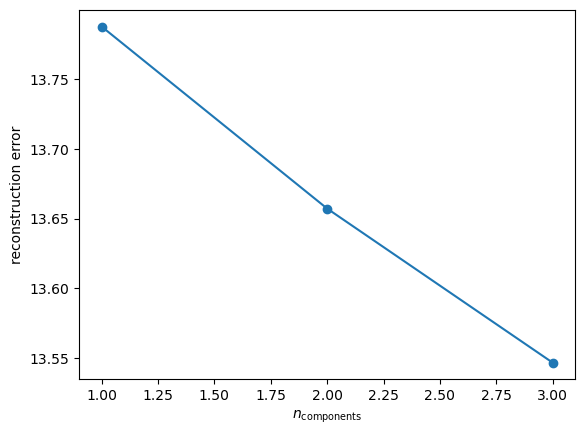

In [87]:
n_components = range(1, corpus['catId'].nunique() + 1)
errors = []
for n_component in n_components:
    nmf_ = NMF(n_component, max_iter=10000)
    nmf_.fit(tf_idf_df)
    errors.append(nmf_.reconstruction_err_)
plt.plot(n_components, errors, '-o')
plt.xlabel(r'$n_\text{components}$')
plt.ylabel('reconstruction error');

In [88]:
n_topics = corpus['catId'].nunique()
n_topics

3

In [89]:
# Instantiate the NMF model & specify the number of topics
# Set random_state for reproducibility
nmf_model = NMF(n_components=n_topics, random_state=1).set_output(transform="pandas")

# Fit the NMF model to the TF-IDF matrix
# Note that the 'H' matrix (topic-term distribution) is in nmf_model.components_
# Note that the 'W' matrix (document-topic distribution) can be obtained with model.transform(tfidf_matrix)
nmf_model.fit(tf_idf_df)

# Function to print the top words for each topic (from search results)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(nmf_model.components_):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [90]:
# Print the top words per topic from search results
# print_top_words(nmf_model, feature_names, topic_no) # uncomment when using topic_no 
print_top_words(nmf_model, feature_names, 10)

Topic #0:
penguin classic classics notes english readers authoritative works best publisher
Topic #1:
new novel life book world york author times sharpe man
Topic #2:
la en el una que su por es los novela



In [91]:
# Get the document-topic distribution
document_topic = nmf_model.transform(tf_idf_df)
document_topic

,nmf0,nmf1,nmf2
0,0.000000,0.122393,0.002109
1,0.000146,0.072206,0.000000
2,0.256219,0.040364,0.000000
3,0.000000,0.000000,0.458081
4,0.000000,0.080588,0.001582
...,...,...,...
192,0.010739,0.115925,0.000000
193,0.010785,0.089239,0.002164
194,0.020501,0.069393,0.000000
195,0.003226,0.071122,0.000473


## Semantic Ranking Using Cosine Similarity

Cosine similarity measures the angular distance between the query’s projected topic vector and each book’s topic vector from the NMF model

This produces relevance scores and enables ranking the entire catalog by semantic similarity to the user’s query.

A reusable query function is implemented:

>Input: A natural-language text query

>Processing: TF-IDF transform → NMF projection → cosine similarity scoring

>Output: Top-10 semantically relevant book titles with metadata

This module forms the end-user interface for book discovery.

#### Step 4. Create a query function

In [ ]:
# Get top words per topic from search results
n_top_words = 10
topic_dict = {}
for topic_idx, topic in enumerate(nmf_model.components_):
        topic_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
topic_dict

#### Cosine Similarity Query

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def nmf_query_search(query, tfidf, nmf, W, top_k=20):

    # 1. Transform query using the SAME TF-IDF model
    q_tfidf = tfidf.transform([query])

    # 2. Project query into SAME NMF topic space
    q_vec = nmf.transform(q_tfidf)

    # 3. Cosine similarity
    sims = cosine_similarity(q_vec, W).ravel()

    # 4. Sort
    top_idx = sims.argsort()[::-1][:top_k]

    return top_idx, sims[top_idx]


In [ ]:
query = 'Romantic Comedy'

In [ ]:
idx, scores =  nmf_query_search(query=query, tfidf=vectorizer, nmf=nmf_model, W=document_topic, top_k=20)
# idx, scores
q_result = corpus.iloc[idx][['isbn', 'title', 'description']]
q_result

In [ ]:
def get_title_categories(isbn):
    params = {
        "api_key": API_KEY,
        "catSetId": "BI",
    }
    cat_url = f"{TITLE_CAT}{isbn}/categories"
    r = session.get(cat_url, params=params, timeout=20)
    print(r)
    print("STATUS:", r.status_code)
    print("URL:", r.url)
    print("RAW:", r.text[:250])

    result = dict(r.json())['data']['categories']
    out = []
    for entry in result:
        out.append(entry['catId'])

    r.raise_for_status()
    return out

In [ ]:
isbn = q_result.iloc[0]['isbn']
isbn

In [ ]:
get_title_categories(isbn)

In [ ]:
def build_catid_confusion_matrix(q_result, target_catid):
    """
    q_result: DataFrame containing ISBNs in column 'isbn'
    target_catid: int, the catId to evaluate

    Returns:
        confusion matrix (DataFrame with rows=Actual, cols=Predicted)
    """

    isbns = q_result["isbn"].tolist()

    rows = []

    for isbn in isbns:
        # Now returns a LIST of catIds
        cat_ids = get_title_categories(isbn)

        # Check if the target category is present
        has_cat = int(target_catid in cat_ids)

        rows.append({"isbn": isbn, "has_cat": has_cat})

    df = pd.DataFrame(rows)

    # All items in q_result are predicted relevant (1)
    df["predicted"] = 1

    # Build confusion matrix
    confusion = pd.crosstab(
        df["has_cat"],
        df["predicted"],
        rownames=["Actual"],
        colnames=["Predicted"]
    )

    return df, confusion

In [ ]:
build_catid_confusion_matrix(q_result, 3000001771)

## Classification Models

In [188]:
# Create dictionary of topic-terms
topic_term_dict = {}
n_top_words = 10
for topic_idx, topic in enumerate(nmf_model.components_):
        topic_term_dict[topic_idx] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
topic_term_dict

{0: ['penguin',
  'classic',
  'classics',
  'notes',
  'english',
  'readers',
  'authoritative',
  'works',
  'best',
  'publisher'],
 1: ['new',
  'novel',
  'life',
  'book',
  'world',
  'york',
  'author',
  'times',
  'sharpe',
  'man'],
 2: ['la', 'en', 'el', 'una', 'que', 'su', 'por', 'es', 'los', 'novela']}

In [189]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np
import time

# Define feature variables and target variable
X = model_df.iloc[:, 5:]
y = model_df['catId'] 

# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [190]:
model_df = corpus.join(document_topic)
model_df

,isbn,title,author,description,catId,nmf0,nmf1,nmf2
0,9780140154078,The Music of Chance,Paul Auster,An exceptional (Los Angeles Times) novel of fa...,3000001526,0.000000,0.122393,0.002109
1,9780142001813,Homo Zapiens,Victor Pelevin,The collapse of the Soviet Union has opened up...,3000001526,0.000146,0.072206,0.000000
2,9780241678916,The Castle,Franz Kafka; Translated by J. A. Underwood; In...,An acclaimed translation of the final work by ...,3000001526,0.256219,0.040364,0.000000
3,9780385492102,El Anatomista,Federico Andahazi,"Publicada por aclamacin pblica en Argentina, E...",3000001526,0.000000,0.000000,0.458081
4,9780425253373,Lunatics,Dave Barry,"Philip Horkman is a happy man, the owner of a ...",3000001526,0.000000,0.080588,0.001582
...,...,...,...,...,...,...,...,...
192,9781594744426,Sense and Sensibility and Sea Monsters,Jane Austen and Ben H. Winters,New York Times bestsellerAn uproarious tale of...,3000001528,0.010739,0.115925,0.000000
193,9781594744600,Android Karenina,Leo Tolstoy and Ben H. Winters,"Leo Tolstoy meets robots in this creepy, thril...",3000001528,0.010785,0.089239,0.002164
194,9781789097313,Uncharted: The Official Movie Novelization,S.D. Perry,The official novelization of the hotly anticip...,3000001528,0.020501,0.069393,0.000000
195,9781913029692,2+2=5,Jake Chapman,A riotous new take on a classic fictional dyst...,3000001528,0.003226,0.071122,0.000473


### Random Forest Classifier

In [229]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train model
start_time = time.time()
rf = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=0)
rf.fit(X_train, y_train)
end_time = time.time()
rf_elapsed_time = end_time - start_time


print("Train set accuracy: {:.2f}".format(rf.score(X_train, y_train)))
print("Test set accuracy: {:.2f}".format(rf.score(X_test, y_test)))

Train set accuracy: 0.99
Test set accuracy: 0.62


In [230]:
# Hyperparamter Tuning
rf_parameters = {'n_estimators':[1, 10, 20, 30, 50, 100], 
                 'max_depth': [1, 2, 5, 10, 20, 30, 50, 100]}
rf_tuned = RandomForestClassifier()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

rf_grid_search = GridSearchCV(estimator = rf_tuned,
                           param_grid = rf_parameters,
                           scoring = 'accuracy',
                           cv = skf)
rf_grid_search.fit(X_train, y_train)

print('Best Parameter Values:', (rf_grid_search.best_params_))
print('Best Model:', (rf_grid_search.best_estimator_))
print('Test Accuracy:', (rf_grid_search.score(X_test, y_test)))

Best Parameter Values: {'max_depth': 5, 'n_estimators': 50}
Best Model: RandomForestClassifier(max_depth=5, n_estimators=50)
Test Accuracy: 0.7


### Gaussian Mixture Model

In [231]:
from sklearn.mixture import GaussianMixture

# Number of classes
n_classes = y.nunique()

# Create Gaussian Mixture Model
start_time = time.time()
gmm = GaussianMixture(
    n_components=n_classes, 
    covariance_type='full',
    random_state=42
)

# Fit model on training data
gmm.fit(X_train)
end_time = time.time()
gmm_elapsed_time = end_time - start_time

# --------------------------------------------------------
# Helper function to map clusters to actual labels
# --------------------------------------------------------
def map_clusters_to_labels(model, X_data, y_data):
    cluster_assignments = model.predict(X_data)
    cluster_to_label = {}

    for cluster in range(model.n_components):
        idx = np.where(cluster_assignments == cluster)[0]
        if len(idx) > 0:
            # most common label among samples in this cluster
            label = y_data.iloc[idx].mode()[0]
        else:
            # fallback if cluster has no points
            label = y_data.mode()[0]
        cluster_to_label[cluster] = label

    return cluster_to_label

# Build mapping using TRAINING data
cluster_to_label = map_clusters_to_labels(gmm, X_train, y_train)

# --------------------------------------------------------
# TRAIN accuracy
# --------------------------------------------------------
train_clusters = gmm.predict(X_train)
y_train_pred = [cluster_to_label[c] for c in train_clusters]
train_accuracy = accuracy_score(y_train, y_train_pred)

# --------------------------------------------------------
# TEST accuracy
# --------------------------------------------------------
test_clusters = gmm.predict(X_test)
y_test_pred = [cluster_to_label[c] for c in test_clusters]
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print both accuracies
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.5987261146496815
Test Accuracy: 0.625


In [232]:
# Hyperparameter Tuning
from sklearn.base import BaseEstimator, ClassifierMixin

# ----------------------------------------------------
# Custom GMM wrapper to make it compatible with sklearn
# ----------------------------------------------------
class GMMClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, n_components=3, covariance_type="full", random_state=42):
        self.n_components = n_components
        self.covariance_type = covariance_type
        self.random_state = random_state

    def fit(self, X, y):
        self.model_ = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            random_state=self.random_state
        )
        self.model_.fit(X)

        # Map clusters → labels using training data
        cluster_assignments = self.model_.predict(X)
        self.cluster_to_label_ = {}

        for cluster in range(self.n_components):
            idx = np.where(cluster_assignments == cluster)[0]
            if len(idx) > 0:
                label = y.iloc[idx].mode()[0]
            else:
                label = y.mode()[0]  # fallback
            self.cluster_to_label_[cluster] = label

        return self

    def predict(self, X):
        clusters = self.model_.predict(X)
        return np.array([self.cluster_to_label_[c] for c in clusters])

# ----------------------------------------------------
# Hyperparameter search space
# ----------------------------------------------------
param_grid = {
    "n_components": [2, 3, 4, 5, 6],
    "covariance_type": ["full", "diag", "tied", "spherical"]
}

# ----------------------------------------------------
# Stratified K-Fold
# ----------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------------------------------
# Grid Search
# ----------------------------------------------------
gmm = GMMClassifier()

grid_search = GridSearchCV(
    estimator=gmm,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# ----------------------------------------------------
# Evaluate best model on test set
# ----------------------------------------------------
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)
tuned_test_accuracy = accuracy_score(y_test, y_pred_test)

# ----------------------------------------------------
# Results
# ----------------------------------------------------
print("Best Parameter Values:", grid_search.best_params_)
print("Best Model:", best_model)
print("Test Accuracy:", tuned_test_accuracy)


Best Parameter Values: {'covariance_type': 'full', 'n_components': 3}
Best Model: GMMClassifier()
Test Accuracy: 0.625


### Logistic Regression

In [233]:
from sklearn.linear_model import LogisticRegression

start_time = time.time()
logreg_l1 = LogisticRegression(solver='liblinear', C = 0.01, penalty='l1', random_state=0)
logreg_l1.fit(X_train, y_train)
end_time = time.time()
logreg_l1_elapsed_time = end_time - start_time

print('Logisic Regression (L1)')
print('Training Set score: {0:0.4f}'. format(logreg_l1.score(X_train, y_train)))
print('Test Set score: {0:0.4f}'. format(logreg_l1.score(X_test, y_test)))

start_time = time.time()
logreg_l2 = LogisticRegression(solver='liblinear', C = 0.01, penalty='l2', random_state=0)
logreg_l2.fit(X_train, y_train)
end_time = time.time()
logreg_l2_elapsed_time = end_time - start_time

print('\nLogisic Regression (L2)')
print('Training Set score: {0:0.4f}'. format(logreg_l2.score(X_train, y_train)))
print('Test Set score: {0:0.4f}'. format(logreg_l2.score(X_test, y_test)))

Logisic Regression (L1)
Training Set score: 0.4586
Test Set score: 0.5000

Logisic Regression (L2)
Training Set score: 0.4841
Test Set score: 0.4750


In [234]:
# Logistic Regression (L1)
l1_parameters = {'C':[0.01, 0.1, 1, 10, 100]}
l1_tuned = LogisticRegression(solver='liblinear', penalty='l1')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

l1_grid_search = GridSearchCV(estimator = l1_tuned,
                           param_grid = l1_parameters,
                           scoring = 'accuracy',
                           cv = skf)
l1_grid_search.fit(X_train, y_train)

print('Logistic Regression (L1)')
print('Best Parameter Values:', (l1_grid_search.best_params_))
print('Best Model:', (l1_grid_search.best_estimator_))
print('Test Accuracy:', (l1_grid_search.score(X_test, y_test)))

# Logistic Regression (L2)
l2_parameters = {'C':[0.01, 0.1, 1, 10, 100]}
l2_tuned = LogisticRegression(solver='liblinear', penalty='l2')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

l2_grid_search = GridSearchCV(estimator = l2_tuned,
                           param_grid = l2_parameters,
                           scoring = 'accuracy',
                           cv = skf)
l2_grid_search.fit(X_train, y_train)

print('\nLogistic Regression (L2)')
print('Best Parameter Values:', (l2_grid_search.best_params_))
print('Best Model:', (l2_grid_search.best_estimator_))
print('Test Accuracy:', (l2_grid_search.score(X_test, y_test)))

Logistic Regression (L1)
Best Parameter Values: {'C': 100}
Best Model: LogisticRegression(C=100, penalty='l1', solver='liblinear')
Test Accuracy: 0.7

Logistic Regression (L2)
Best Parameter Values: {'C': 100}
Best Model: LogisticRegression(C=100, solver='liblinear')
Test Accuracy: 0.7


### Linear SVM

In [235]:
from sklearn.svm import LinearSVC

start_time = time.time()
linear_svm = LinearSVC(C=1.0, random_state=0)
linear_svm.fit(X_train, y_train)
end_time = time.time()
svm_elapsed_time = end_time - start_time

print('Training Set score: {0:0.4f}'. format(linear_svm.score(X_train, y_train)))
print('Test Set score: {0:0.4f}'. format(linear_svm.score(X_test, y_test)))

Training Set score: 0.5924
Test Set score: 0.6500


In [236]:
# Hyperparameter Tuning
svm_parameters = {'C':[0.01, 0.1, 1, 10, 100]}
svm_tuned = LinearSVC()
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

svm_grid_search = GridSearchCV(estimator = svm_tuned,
                           param_grid = svm_parameters,
                           scoring = 'accuracy',
                           cv = skf)
svm_grid_search.fit(X_train, y_train)

print('Linear SVM')
print('Best Parameter Values:', (svm_grid_search.best_params_))
print('Best Model:', (svm_grid_search.best_estimator_))
print('Test Accuracy:', (svm_grid_search.score(X_test, y_test)))

Linear SVM
Best Parameter Values: {'C': 10}
Best Model: LinearSVC(C=10)
Test Accuracy: 0.7


### Summary ML Models

In [237]:
cols = ['Method', 'Train Accuracy', 'Test Accuracy', 'Tuned Test Accuracy', 'Elapsed Time']
ml_models = pd.DataFrame(columns=cols)

ml_models.loc[0] = ['Random Forest', 
                    rf.score(X_train, y_train),
                    rf.score(X_test, y_test), 
                    rf_grid_search.score(X_test, y_test),
                    rf_elapsed_time]

ml_models.loc[1] = ['Gaussian Mixture Model', 
                    train_accuracy,
                    test_accuracy, 
                    tuned_test_accuracy,
                    gmm_elapsed_time]

ml_models.loc[2] = ['Logistic Regression (L1)', 
                    logreg_l1.score(X_train, y_train),
                    logreg_l1.score(X_test, y_test), 
                    l1_grid_search.score(X_test, y_test),
                    logreg_l1_elapsed_time]
ml_models.loc[3] = ['Logistic Regression (L2)', 
                    logreg_l2.score(X_train, y_train),
                    logreg_l2.score(X_test, y_test), 
                    l2_grid_search.score(X_test, y_test),
                    logreg_l2_elapsed_time]

ml_models.loc[4] = ['Linear SVM', 
                    linear_svm.score(X_train, y_train),
                    linear_svm.score(X_test, y_test), 
                    svm_grid_search.score(X_test, y_test),
                    svm_elapsed_time]

ml_models

,Method,Train Accuracy,Test Accuracy,Tuned Test Accuracy,Elapsed Time
0,Random Forest,0.993631,0.625,0.700,0.099451
1,Gaussian Mixture Model,0.598726,0.625,0.625,0.007619
2,Logistic Regression (L1),0.458599,0.500,0.700,0.004110
3,Logistic Regression (L2),0.484076,0.475,0.700,0.004067
4,Linear SVM,0.592357,0.650,0.700,0.003388
